In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
def set_device():
    """
    Set the device. CUDA if available, otherwise CPU.
    
    Args: None
    
    Returns: Nothing   
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("This notebook will be running on CPU!")
    else: 
        print("You have CUDA set up! Woohoo!!!")
        
    return device

In [3]:
# SEED = 2023
# set_seed(seed=SEED)
DEVICE = set_device()

This notebook will be running on CPU!


In [4]:
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
          
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [5]:
basal_ganglia_regions = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
visual_cortex_regions = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]

total_vc_neurons=0
total_bg_neurons=0

sessions_to_use = []  ##Session indices
session_lengths = []  ##The number of trials in each session
input_visual_tensor_list = []
label_basal_tensor_list = []

for session in range(len(alldat)):
  num_vis_neurons = 0
  num_basal_neurons = 0
  vis_neuron_indices = []
  basal_neuron_indices = []
  for neuron_idx, area in enumerate(alldat[session]['brain_area']):
    if area in visual_cortex_regions:  ## Viusal areas
      num_vis_neurons += 1
      vis_neuron_indices.append(neuron_idx)
    if area in basal_ganglia_regions:  ## Basal Ganglia
      num_basal_neurons += 1
      basal_neuron_indices.append(neuron_idx)
          
  trial_num = alldat[session]['spks'].shape[1]   
  input_visual_recordings = np.empty((num_vis_neurons, trial_num, 250))
  label_basal_recordings = np.empty((num_basal_neurons, trial_num, 250))
  
  
  if num_vis_neurons*num_basal_neurons != 0:
    sessions_to_use.append(session)
    print("session " ,session, "has both visual and basal!")
    print('The name of the mouse: ' + alldat[session]['mouse_name'])
    print('The session time' + alldat[session]['date_exp'])
    print(alldat[session]['spks'].shape)

    print('The number of neurons being recorded:', len(alldat[session]['spks']))
    print('Number of visual neurons: ', num_vis_neurons)
    # print('Indices of visual neurons: ', vis_neuron_indices)
    
    ## To extract the data from alldat[current_session]
    for i, v in enumerate(vis_neuron_indices): 
      input_visual_recordings[i, :, :] = alldat[session]['spks'][v, :, :]
    print("reorganized visual activities for input: ", input_visual_recordings.shape)
    print('Number of basal neurons: ', num_basal_neurons)
    # print('Indices of basal neurons: ', basal_neuron_indices)
    for i, g in enumerate(basal_neuron_indices):
      label_basal_recordings[i, :, :] = alldat[session]['spks'][g, :, :]
    print("reorganized basal activities for label", label_basal_recordings.shape)
    print('----------------------------------------------------')
    
    visual_input_tensor = torch.from_numpy(input_visual_recordings).reshape(-1, 250)
    input_visual_tensor_list.append(visual_input_tensor)
    basal_label_tensor = torch.from_numpy(label_basal_recordings).reshape(-1, 250)
    label_basal_tensor_list.append(basal_label_tensor)

# input = torch.cat(input_visual_tensor_list, axis = 0)
# label = torch.cat(label_basal_tensor_list, axis = 0)
# !!!!!! I realized that the firing rate across different sessions have huge variations, so it may not be a good idea to combine them together!!!!!\

print("input tensor list: We have", len(input_visual_tensor_list), "and their shapes are ", [input_visual_tensor_list[i].shape for i in range(len(input_visual_tensor_list))])
print("label tensor list: We have", len(label_basal_tensor_list), "and their shapes are", [label_basal_tensor_list[i].shape for i in range(len(label_basal_tensor_list))])


session  0 has both visual and basal!
The name of the mouse: Cori
The session time2016-12-14
(734, 214, 250)
The number of neurons being recorded: 734
Number of visual neurons:  178
reorganized visual activities for input:  (178, 214, 250)
Number of basal neurons:  139
reorganized basal activities for label (139, 214, 250)
----------------------------------------------------
session  3 has both visual and basal!
The name of the mouse: Forssmann
The session time2017-11-01
(1769, 249, 250)
The number of neurons being recorded: 1769
Number of visual neurons:  120
reorganized visual activities for input:  (120, 249, 250)
Number of basal neurons:  435
reorganized basal activities for label (435, 249, 250)
----------------------------------------------------
session  7 has both visual and basal!
The name of the mouse: Hench
The session time2017-06-15
(1156, 250, 250)
The number of neurons being recorded: 1156
Number of visual neurons:  111
reorganized visual activities for input:  (111, 250,

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [6]:
### 2024/07/15 We set the turncation threshold to be 50 neurons
## adding reshape methods -- please go over the code to see if modified/added "aspects" are consistent 
## and do what they are intended to do, the number of neurons went down (perhaps a little bit more than intended)
## and the same for the trial number, but now they match in dimensions

import torch 
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    """
    I tried to make it tailored to our needs.
    It only considers sessions that have both visual and basal ganglia recordings.
    It only considers go trials.
    When indexed, it returns basal ganglia spikes and action).
    """

    def __init__(
        self,
        data,
        visual_cortex_regions: list = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # Put them as default argument so they can be easily changed if we decide to change areas
        basal_ganglia_regions: list = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],
        thresh=50
    ) -> None:
        
        self.visual_cortex_regions = visual_cortex_regions
        self.basal_ganglia_regions = basal_ganglia_regions
        self.thresh=thresh
        self.data = self.visual_and_basal(data)
        self.data = self.get_go_trials(self.data)
        self.min_trials, self.min_neurons = self.find_min_dimensions(self.data) # new 
        print(f"Minimum number of trials: {self.min_trials}")
        print(f"Minimum number of neurons: {self.thresh}")

    def __getitem__(
        self,
        session_index: int
    ) -> torch.tensor:
        
        session = self.data[session_index]
        
        # Since we don't need the visual spks so I am commentting this out. (YD, 07/16)
        spikes_visual = self.get_truncated_spikes(session, self.visual_cortex_regions)
        
        ## Some number checks by Yangdong 24/7/15
        ## print("the shape of spikes_visual after truncating:", spikes_visual.shape)

        basal_spks = self.get_truncated_spikes(session, self.basal_ganglia_regions) # This will be the input data (time, trials, eurons_indicies)          
        label_action = torch.tensor(session['response'][0:self.min_trials]) #(-1: the mouse is turning the wheel to the left, which indicates that the mouse thinks the right side has higher contrast level. )
        
        return spikes_visual, basal_spks

    def __len__(self):
      return len(self.data)

    def visual_and_basal(
        self,
        data: np.array
    ) -> list:
        """
        It checks whether any of the considered brain areas recorded in the session
        is present in both visual or basal regions.
        Also excludes sessions with a number of neurons < self.threshold
        """
      
        visual_and_basal_sessions = []
        for session in data:
        
            visual_ok = any(area in self.visual_cortex_regions for area in session["brain_area"]) 
            basal_ok = any(area in self.basal_ganglia_regions for area in session["brain_area"]) 
            vis_neuron_count = len([i for i, area in enumerate(session["brain_area"]) if area in self.visual_cortex_regions])
            bg_neuron_count = len([i for i, area in enumerate(session["brain_area"]) if area in self.basal_ganglia_regions])
            min_count = np.min([vis_neuron_count, bg_neuron_count])

            if visual_ok and basal_ok and min_count>self.thresh:
                visual_and_basal_sessions.append(session)

        return visual_and_basal_sessions  
        ## a list of actual sessions (with all datas) which contains both, and the number of neurons is larger than the threshold...

    def get_go_trials(
        self,
        data: list
    ) -> list:
        """
        Within sessions, excludes no-go trials.
        """
        sessions_with_go_trials = []
        for session in data:
            go_trial_indices = [i for i, response in enumerate(session["response"]) if response != 0]
            if go_trial_indices:
                filtered_session = {} # sessions are dicts
                for key, value in session.items():
                    # Include all the keys of the session dictionary
                    if isinstance(value, np.ndarray) and value.ndim > 1 and value.shape[1] == len(session["response"]): # like "spks" is multidimensional
                        filtered_session[key] = value[:, go_trial_indices]
                    elif isinstance(value, np.ndarray) and len(value) == len(session["response"]): # like "response is 1 dimensional"
                        filtered_session[key] = value[go_trial_indices]
                    else: # like "mouse_name" is a single value
                        filtered_session[key] = value
                sessions_with_go_trials.append(filtered_session)
        
        return sessions_with_go_trials  

    def find_min_dimensions(
        self,
        data: list
    ) -> tuple:
        min_trials = float('inf')
        min_neurons = float('inf')
        """
        Helper function to establish """        
        
        for session in data:
            spikes = session["spks"]  ## [neurons_number, trial_Indexes, time]
            min_trials = min(min_trials, spikes.shape[1])
            # min_neurons = min(min_neurons, spikes.shape[0])
        
        return min_trials, min_neurons

    def get_truncated_spikes(
        self,
        session: dict,
        regions: list
    ) -> torch.tensor:

        neuron_indices = [i for i, area in enumerate(session["brain_area"]) if area in regions]
        spikes = session["spks"][neuron_indices, :, :]  ## containing spks from visual/basal areas, e.g 17
        spikes = spikes[:self.thresh, :, :] 
        spikes = spikes[:, :self.min_trials, :]

        spikes = torch.tensor(spikes)
        spikes = torch.permute(spikes, (2,0,1))  ## time, neuron_index, trial_index

        # 24/07/15 -> Dario: should we leave the conversion to tensor in the __getitem__ method?

        return spikes
    
    def sanity_check(self):
        for idx, session in enumerate(self.data):
            spikes_visual = self.get_truncated_spikes(session, self.visual_cortex_regions)
            spikes_basal = self.get_truncated_spikes(session, self.basal_ganglia_regions)

            assert spikes_visual.shape[1] == self.min_trials, f"Session idx visual cortex trials mismatch."
            assert spikes_visual.shape[2] == self.min_neurons, f"Session idx visual cortex neurons mismatch."
            assert spikes_basal.shape[1] == self.min_trials, f"Session idx basal ganglia trials mismatch."
            assert spikes_basal.shape[2] == self.min_neurons, f"Session idx basal ganglia neurons mismatch."
    print("Sanity check clear")

thresh=50
all_data = CustomDataset(alldat)
x = all_data[0]

print("We have", len(all_data), "number of sessions.")
print("Each of the session has", all_data[0][0].shape[2], "trials, and", all_data[0][0].shape[1], "neurons.")
print("We have", 123*6, "input basal spike matrx.")


Sanity check clear
Minimum number of trials: 123
Minimum number of neurons: 50
We have 6 number of sessions.
Each of the session has 123 trials, and 50 neurons.
We have 738 input basal spike matrx.


In [7]:
# a = (all_data[0][0], all_data[0][1])  # Initialize 'a' with the first tuple's tensors.

merged = all_data[0]

for i, session in enumerate(all_data):  # Start from the second element.
    # print(i)
    if i == 0: continue
    merged = (torch.cat((merged[0], session[0]), dim=2),  # Concatenate along dim=2 for the first tensor.
         torch.cat((merged[1], session[1]), dim=2))         # Simply concatenate along the last dimension for the second tensor.

print(merged[0].shape, merged[1].shape)

torch.Size([250, 50, 738]) torch.Size([250, 50, 738])


In [8]:
import numpy as np
import torch
import random
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

class Session_New(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        input_spikes = self.data[0][:, :, idx] # input_spikes has the shape (time, neuron_index)
        label_spikes = self.data[1][:, :, idx] # has the action tensor (1) or (-1).
        return input_spikes, label_spikes

def split(dataset, validation_split=0.2, test_split = 0.2, shuffle_trials=True, batch_size=20):
    num_trials = merged[0].shape[2]
    indices = list(range(num_trials))
    validation_split_index = int(np.floor(validation_split * num_trials))
    test_split_index = int(np.floor(test_split * num_trials)) + validation_split_index
    if shuffle_trials:
        np.random.shuffle(indices)
    
    train_indices = indices[test_split_index:]
    test_indices =  indices[validation_split_index:test_split_index]
    val_indices = indices[:validation_split_index]
    
    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    dataset = Session_New(dataset)
    
    train_loader = DataLoader(dataset, 
                              batch_size=batch_size, 
                              sampler = train_sampler
                              )
    valid_loader = DataLoader(dataset, 
                              batch_size=batch_size, 
                              sampler = valid_sampler
                              )
    test_loader = DataLoader(dataset, 
                             batch_size=batch_size, 
                             sampler = test_sampler)
    
    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = split(merged)

# for batch_index, (batch_neural_recordings, batch_actions) in enumerate(train_loader):
#     print(f"Batch index: {batch_index}:")
#     print(f"batch_neural_recordings shape: {batch_neural_recordings.shape}")
#     print(f"Batch_actions: {batch_actions}")
#     
print("-------------------------------------------------------------------")
# 
# for batch_index, (batch_neural_recordings, batch_actions) in enumerate(valid_loader):
#     print(f"Batch index: {batch_index}:")
#     print(f"batch_neural_recordings shape: {batch_neural_recordings.shape}")
#     print(f"Batch_actions: {batch_actions}")

-------------------------------------------------------------------


In [9]:
from sklearn.preprocessing import StandardScaler
def z_score(X):
    # X: ndarray, shape (n_neurons, n_timebins)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

def normalization(data):
    '''
    
    We normalize the data before feeding it into the forward function. It is important to keep other attributes from data loader hence the following codes with seemingly weird logic.
    
    :param data: input tensor (1, 1, 250, 50)
    :return: the 2 and 3rd dimension of data tensor got normalized
    '''
 
    for i in range(data.shape[0]):
        data = data.float()
        x = data[i, :, :]
        x = torch.transpose(x, 0, 1).numpy()
        x = z_score(x)
        x = x.T
        x = torch.tensor(x, dtype=torch.float)
        data[i, :, :] = x
    
    return data
    

In [10]:
class BiasLayer(nn.Module):
  """
  Bias Layer
  """

  def __init__(self, shape):
    """
    Initialise parameters of bias layer

    Args:
      shape: tuple
        Requisite shape of bias layer

    Returns:
      Nothing
    """
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input features

    Returns:
      Output of bias layer
    """
    return x + self.bias

In [11]:
def cout(x, layer):
  """
  Unnecessarily complicated but complete way to
  calculate the output depth, height
  and width size for a Conv2D layer

  Args:
    x: tuple
      Input size (depth, height, width)
    layer: nn.Conv2d
      The Conv2D layer

  Returns:
    Tuple of out-depth/out-height and out-width
    Output shape as given in [Ref]
    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

In [12]:
class ConvAutoEncoder(nn.Module):
  """
  A Convolutional AutoEncoder
  """

  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5, batch_n = 20):
    """
    Initialize parameters of ConvAutoEncoder

    Args:
      x_dim: tuple
        Input dimensions (channels, height, widths)
      h_dim: int
        Hidden dimension, bottleneck dimension, K
      n_filters: int
        Number of filters (number of output channels)
      filter_size: int
        Kernel size

    Returns:
      Nothing
    """
    super().__init__()
    channels, height, widths = x_dim

    # Encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # First encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # Output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # Second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # Output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # Conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # Encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    # Decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # Unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # First "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # Second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # Decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    """
    Encoder

    Args:
      x: torch.tensor
        Input features

    Returns:
      h: torch.tensor
        Encoded output
    """
    s = self.enc_bias(x)
    s = s.unsqueeze(1)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    """
    Decoder

    Args:
      h: torch.tensor
        Encoded output

    Returns:
      x_prime: torch.tensor
        Decoded output
    """
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    x_prime = x_prime.squeeze(1)
    return x_prime

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input features

    Returns:
      Decoded output
    """
    return self.decode(self.encode(x))

data_shape = (1, 250, 50)
K = 50
trained_conv_AE = ConvAutoEncoder(data_shape, K)
# assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
# 
# plot_conv_ae(lin_losses, conv_losses)

In [13]:
def train_autoencoder(autoencoder, device, epochs=50, batch_size=20, beta_1 = 0.7, beta_2 = 0.99):
  """
  Function to train autoencoder

  Args:
    autoencoder: nn.module
      Autoencoder instance
    dataset: function
      Dataset
    device: string
      GPU if available. CPU otherwise
    epochs: int
      Number of epochs [default: 20]
    batch_size: int
      Batch size
    seed: int
      Set seed for reproducibility; [default: 0]

  Returns:
    mse_loss: float
      MSE Loss
  """
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=0.001,
                           weight_decay=1e-4,
                           betas = (beta_1, beta_2))
  loss_fn = nn.MSELoss()
  train_mse_loss = []
  valid_mse_loss = []
  
  i = 0
  for epoch in range(epochs):
    for data, target in train_loader:
      data = normalization(data)
      data = data.to(device)
      optim.zero_grad()
      # im_batch = torch.mean(im_batch, dim=0)
      reconstruction = autoencoder.forward(data)
      # Loss calculation
      target = target.to(device).float()
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target.view(batch_size, -1))
      loss.backward()
      optim.step()

      train_mse_loss.append(loss.detach().cpu())
      
        
    for data, target in valid_loader:
      data = normalization(data)
      data = data.to(device)
      optim.zero_grad()
      # im_batch = torch.mean(im_batch, dim=0)
      reconstruction = autoencoder.forward(data)
      # Loss calculation
      target = target.to(device).float()
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target.view(batch_size, -1))

      valid_mse_loss.append(loss.detach().cpu())
    
    i += 1
    print(f'Epoch {epoch + 1}/{epochs}, Train MSE Loss: {train_mse_loss[i-1]}, Validation MSE loss: {valid_mse_loss[i-1]}')
  # After training completes,
  # make sure the model is on CPU so we can easily
  # do more visualizations and demos.  
  autoencoder.to('cpu')
  
  return train_mse_loss, valid_mse_loss

train_mse_loss, valid_mse_loss = train_autoencoder(trained_conv_AE, device=DEVICE)   

Epoch 1/50, Train MSE Loss: 0.02303471602499485, Validation MSE loss: 0.034522462636232376
Epoch 2/50, Train MSE Loss: 19.80874252319336, Validation MSE loss: 0.03186388313770294
Epoch 3/50, Train MSE Loss: 0.07453399151563644, Validation MSE loss: 0.032012589275836945
Epoch 4/50, Train MSE Loss: 0.2348281443119049, Validation MSE loss: 0.03367192670702934
Epoch 5/50, Train MSE Loss: 0.2244008481502533, Validation MSE loss: 0.03634781017899513
Epoch 6/50, Train MSE Loss: 0.15299850702285767, Validation MSE loss: 0.03667579963803291
Epoch 7/50, Train MSE Loss: 0.1491677463054657, Validation MSE loss: 0.03227145969867706
Epoch 8/50, Train MSE Loss: 0.09248887747526169, Validation MSE loss: 0.035423509776592255
Epoch 9/50, Train MSE Loss: 0.07588248699903488, Validation MSE loss: 0.02541937306523323
Epoch 10/50, Train MSE Loss: 0.06601395457983017, Validation MSE loss: 0.024744221940636635
Epoch 11/50, Train MSE Loss: 0.06183244287967682, Validation MSE loss: 0.02089347131550312
Epoch 12/

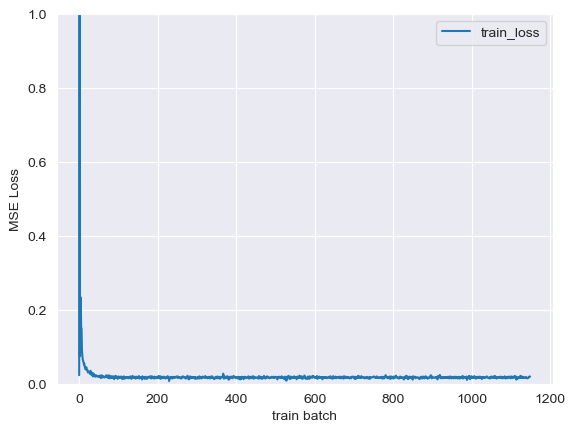

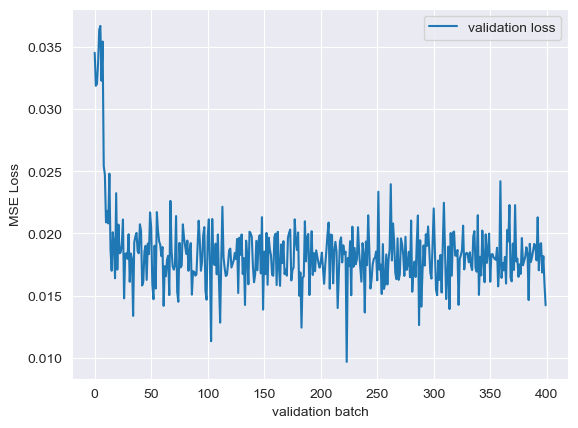

In [15]:
plt.figure()
plt.plot(train_mse_loss)
plt.legend(['train_loss'])
plt.xlabel('train batch')
plt.ylabel('MSE Loss')
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(valid_mse_loss)
plt.legend(['validation loss'])
plt.xlabel('validation batch')
plt.ylabel('MSE Loss')
#plt.ylim([0,2*torch.as_tensor(conv_losses).median()])
plt.show()

In [ ]:
def test_model(test_loader, model):
    
    test_mse_loss = []
    
    for data, target in test_loader: 
        data = data.float()
        # im_batch = torch.mean(im_batch, dim=0)
        loss_fn = nn.MSELoss()
        batch_size = 20
        reconstruction = model.forward(data)
        # Loss calculation
        loss = loss_fn(reconstruction.view(batch_size, -1),target.view(batch_size, -1))

        test_mse_loss.append(loss.detach())
    
    return test_mse_loss

test_mse_lost = test_model(test_loader, trained_conv_AE)

In [18]:
visual_spks = merged[0]
basal_spks = merged[1]

In [25]:
predicted = torch.zeros(visual_spks.shape)
for i in range(visual_spks.shape[2]):
    input_v = visual_spks[:, :, i].unsqueeze(0)
    input_v = normalization(input_v)
    output = trained_conv_AE.forward(input_v)
    predicted[:, :, i] = output.squeeze(0)
    

In [32]:
visual_spks = visual_spks.float()
predicted = predicted.float()
visual_spks_mean = torch.mean(visual_spks, dim = 2).detach().numpy()
predicted_mean = torch.mean(predicted, dim = 2).detach().numpy()

In [37]:
basal_spks = basal_spks.float()
basal_spks = normalization(basal_spks)
basal_spks_mean = (torch.mean(basal_spks, dim = 2).detach().numpy())

<Axes: >

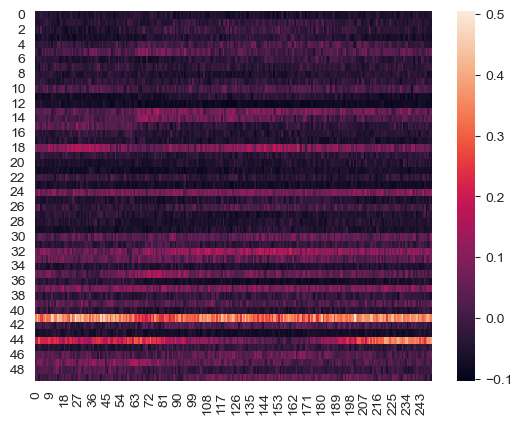

In [41]:
import seaborn as sns
sns.heatmap(basal_spks_mean.T)

<Axes: >

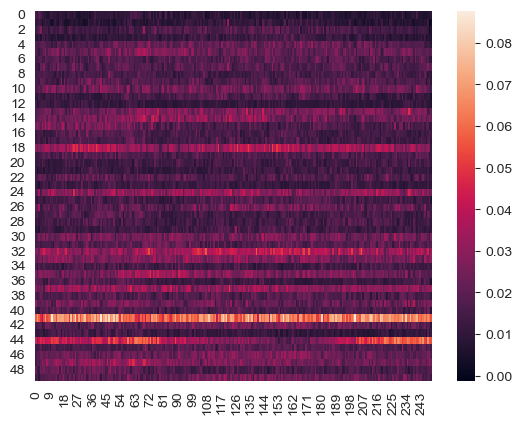

In [42]:
sns.heatmap(predicted_mean.T)